- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) 
- **Date:** August 2026  
- **conda environment**: [mri conda environment](../mri_environment.yml).

# fMRI Data Analysis: Region Of Interest (ROI) Analysis

Along with whole-brain analysis, it is common to perform region-of-interest (ROI) analysis on fMRI data. This involves extracting signals from specified ROIs. ROI analysis is valuable for several reasons, including **data exploration**, **statistical control**, and **functional specification**. For more information, see this brief review paper by R. Poldrack (2007): https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2555436/.

ROIs can be defined based on brain structure or function. For **structural ROIs**, it is recommended to define them based on each subject's anatomy wherever possible. However, this is not always possible, or feasible. In such cases, one can use ROIs based on probabilistic or (less preferable) deterministic atlases. **Functional ROIs** can be defined from 'localiser' scans that identify specific regions exhibiting a particular response (e.g., 'face area' in the fusiform gyrus that respond more strongly to faces than to non-faces). Alternatively, functional ROIs can be defined using **independent contrasts** (make sure you don't do ['double dipping'](https://www.nature.com/articles/nn.2303)) within a factorial design or derived **from previous studies**.

In this tutorial, we demonstrate three common types of ROIs: a single voxel, a sphere around a voxel, and a ROI from a probabilistic atlas.

1. **A single voxel** is used when the hypothesis is very precise, aiming to identify a specific point in the brain that corresponds to a known functional or anatomical feature. When identifying peak activity within a region, reporting the single voxel with the maximum signal can be informative. There is no risk of averaging signals from different functional areas, which can occur when using larger ROIs. However, single voxels are more susceptible to noise and may represent spurious activity, leading to less reliable results. Additionally, findings based on a single voxel may be less generalisable.

2. **A spherical ROI** can help to average out noise and increase the reliability of the signal, as well as generalisability across studies. However, averaging across multiple voxels can reduce anatomical and functional specificity, potentially blurring the precise location of the activity.

3. **A probabilistic atlas** is commonly used when investigating brain regions that are functionally or anatomically well-characterised in the literature and show consistent properties across individuals. Using a probabilistic atlas allows for more straightforward comparisons between studies, as the ROIs are defined using the same criteria across different datasets. This enhances the reproducibility and comparability of results. Probabilistic atlases help reduce subjective decisions about where to place ROIs, thereby minimising experimenter bias. Unlike deterministic atlases (which are also commonly used), probabilistic atlases account for some variability in the exact location across subjects. However, they still represent an average across individuals, which might not fully capture the specific anatomy or function of a region in a particular subject. 

It is common, and often advisable, to perform **ROI analysis in a subject's native space** (using their original brain images without normalisation). In this tutorial, we will also provide an example of how to transform an MNI-space ROI to a subject's native space for native-space analysis.

---

**Table of contents**    
1. Import required packages and set up some stuff   
2. Load the subject-level fMRI results    
3. A single voxel ROI    
3.1. Function `extract_MNI_voxel_data`    
4. A spherical ROI  
4.1. Function `create_voxel_sphere`   
4.2. Function `create_MNIvoxel_sphere`   
4.3. Function `extract_mean_ROI_values`    
5. A ROI from a probabilistic atlas   
6. Transforming MNI-space ROI to native-space for native-space analysis    
7. Statistics and plotting of the ROI data    
7.1. Paired t-test: Initial vs Repeated Faces in the Right Fussiform Gyrus    
7.2. Three-way RM ANOVA. Initial vs Immediate Repetition vs Delayed Repetition in the Right Fusiform Gyrus    
7.3. Two-by-Two RM ANOVA. Repetition effect for Familiarity x Lag in the Right Fusiform Gurys    
7.4. Familiar vs Unfamiliar Faces in Amygdala    

-----
## Import required packages and set up some stuff

In [1]:
import os.path as op # for file path operations
import pandas as pd # for data manipulation
import numpy as np # for numerical operations

# Plotting libraries
import matplotlib.pyplot as plt # basic plots
import seaborn as sns # better looking plots

# BIDS library
from bids import BIDSLayout # to query BIDS dataset

# Stats libraries
from scipy import stats 
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# # Nilearn modules https://nilearn.github.io/
from nilearn.datasets import load_mni152_template
from nilearn.plotting import plot_roi
from nilearn.image import resample_to_img, binarize_img, math_img
from nilearn.masking import _unmask_3d, compute_brain_mask
from nilearn.maskers import nifti_spheres_masker

import nibabel as nib # NiBabel, to read and write neuroimaging data, https://nipy.org/nibabel/
import ants # ANTsPy (Advanced Normalization Tools), https://github.com/ANTsX/ANTsPy

In [2]:
# MNI152 template will be used as a backgound for plotting MNI-space ROIs
mni152_template = load_mni152_template() 

# ROI MNI coordinates. Taken from the group-level results
ROI_label = 'Right Fusiform Gyrus'
MNI_coord = (42,	-54,	-18)

## Load the subject-level fMRI results

In [3]:
# --- Set up the paths to the data and results folders
fmri_data_dir = '../example_data/FaceRecognition/data' # data in BIDS format
fmri_results_dir = '../example_data/FaceRecognition/results' # results in BIDS format

# --- Set up the BIDS layout
layout = BIDSLayout(fmri_data_dir, derivatives = True)

# Attach the results folder to the layout. It must complay with BIDS standards. 
# And must include dataset_description.json file!
layout.add_derivatives(op.join(fmri_results_dir, "first-level"))

# --- Get all subject-level effect files for the specified conditions
conditions = ['IniFF', 'ImmFF', 'DelFF', 'IniUF', 'ImmUF', 'DelUF']
effect_files = layout.get(desc=conditions, suffix='effect', extension='.nii.gz')

# Print how many files there are to check if it is correct
nsub = len(layout.get_subjects())
ncond = len(conditions)
print(f"\nFound {len(effect_files)} files. Should be {nsub} subjects * {ncond} conditions = {nsub * ncond}\n")
# Print them for inspection
print(*effect_files, sep="\n")


Found 96 files. Should be 16 subjects * 6 conditions = 96

<BIDSImageFile filename='/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-01/sub-01_ses-mri_task-facerecognition_desc-DelFF_effect.nii.gz'>
<BIDSImageFile filename='/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-01/sub-01_ses-mri_task-facerecognition_desc-DelUF_effect.nii.gz'>
<BIDSImageFile filename='/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-01/sub-01_ses-mri_task-facerecognition_desc-ImmFF_effect.nii.gz'>
<BIDSImageFile filename='/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-01/sub-01_ses-mri_task-facerecognition_desc-ImmUF_effect.nii.gz'>
<BIDSImageFile filename='/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-01/sub-01_ses-mr

## A single voxel ROI

In this section, we demonstrate how to extract voxel-specific data from a set of fMRI result files using given MNI coordinates. It is assumed that the result files are all in MNI space. 

The goal of the `extract_MNI_voxel_data` function is to loop through a list of fMRI result files, identify the voxel corresponding to the provided MNI coordinates, and extract the activation value at that voxel for each subject and condition. The function will return a table (DataFrame) containing the subject ID, condition name, original MNI coordinates, corresponding voxel coordinates in voxel space, and the extracted voxel value. This data can then be used for further statistical analysis and visualisation.

### Function `extract_MNI_voxel_data`

In [4]:
def extract_MNI_voxel_data(result_files, MNI_coord):
    """
    Extract voxel data from a list of results files at given MNI coordinates.

    Parameters:
    - result_files: List of BIDSImageFiles, or a list of file names as strings, containing subject-level results in MNI space.
    - MNI_coord: Tuple of MNI coordinates (x, y, z).

    Returns:
    - DataFrame with columns: 'subject', 'condition', 'voxel', 'value'.
    """
    
    # Initialize an empty list to store the data
    data_list = []

    # Loop through the files and extract the values to add to the list
    for file in result_files:
        # If file is not a BIDSImageFile, but a string, load it
        if isinstance(file, str):
            file = layout.get_file(file)
      
        # Get the subject ID
        subject = file.get_entities()['subject']
        
        # Get the condition name
        condition = file.get_entities()['desc']
        
        # Get the voxel coordinates from the MNI coordinates
        img = file.get_image() # contains data as a 3D numpy array, affine matrix, header.
        inverse_affine = np.linalg.inv(img.affine)
        vox_coord = nib.affines.apply_affine(inverse_affine, MNI_coord)
        
        # Get the voxel value
        vox_value = img.get_fdata()[int(vox_coord[0]), int(vox_coord[1]), int(vox_coord[2])]
        
        # Append the data to the list
        data_list.append([subject, condition, MNI_coord, vox_coord, vox_value.item()])
    
    # Convert the list to a DataFrame
    data = pd.DataFrame(data_list, columns=['subject', 'condition', 'MNI', 'voxel', 'value'])
    
    return data

Now we can use the function to extract the contrast values of the specified voxel from the subject-level results.

In [5]:
data_from_MNI_coord = extract_MNI_voxel_data(effect_files, MNI_coord) 

print(data_from_MNI_coord)

   subject condition             MNI               voxel     value
0       01     DelFF  (42, -54, -18)  [44.0, 24.0, 18.0]  0.437220
1       01     DelUF  (42, -54, -18)  [44.0, 24.0, 18.0]  0.211807
2       01     ImmFF  (42, -54, -18)  [44.0, 24.0, 18.0]  0.169414
3       01     ImmUF  (42, -54, -18)  [44.0, 24.0, 18.0]  0.246282
4       01     IniFF  (42, -54, -18)  [44.0, 24.0, 18.0]  0.375363
..     ...       ...             ...                 ...       ...
91      16     DelUF  (42, -54, -18)  [44.0, 24.0, 18.0]  0.117875
92      16     ImmFF  (42, -54, -18)  [44.0, 24.0, 18.0]  0.166809
93      16     ImmUF  (42, -54, -18)  [44.0, 24.0, 18.0]  0.111768
94      16     IniFF  (42, -54, -18)  [44.0, 24.0, 18.0]  0.212782
95      16     IniUF  (42, -54, -18)  [44.0, 24.0, 18.0]  0.161001

[96 rows x 5 columns]


## A spherical ROI

In this section, we provide two examples of how to create a spherical ROI around a specific voxel in a 3D MRI image and then extract the mean values from this ROI across multiple fMRI result files.

* The first function, `create_voxel_sphere`, can be applied to images in any space (native, MNI, etc.). The input voxel coordinates should be in voxel-space. If your image is in MNI-space and you have the MNI coordinates around which you want to create the sphere, you can obtain the corresponding voxel coordinates either programmatically (see the function *extract_MNI_voxel_data* above – *# Get the voxel coordinates from the MNI coordinates*) or by using visualisation tools like FSLeyes. In FSLeyes, you can open the image, enter the MNI coordinates, and it will display the corresponding voxel coordinates. (You can also easily adjust the function to be more flexible, allowing it to accept either MNI or voxel-space coordinates.) The function constructs a spherical mask in voxel-space around a specified centre voxel, with a radius defined in millimetres. If a *brain_mask* is provided, the spherical ROI will be constrained within that mask.

* The second function, `create_MNIvoxel_sphere`, uses built-in Nilearn functions to achieve the same result as the first function but expects the input coordinates to be in MNI-space (or another world-space) coordinates.

Once the spherical ROI is created, the `extract_mean_ROI_values` function can be used to extract and compute the mean activation values within this ROI across multiple fMRI result files. The extracted data can then be used for statistical analysis.

### Function `create_voxel_sphere`

In [6]:
def create_voxel_sphere(base_img, center_voxel, radius_mm, brain_mask=None):
  
    """
    Create a spherical mask around a specified voxel in a 3D MRI image.

    Parameters:
    base_img (nibabel.Nifti1Image): A 3D Nifti1Image that defines the space in which the sphere will be created..
    center_voxel (tuple): The (x, y, z) coordinates of the center voxel, in voxel space.
    radius_mm (float): The radius of the sphere in millimeters.
    brain_mask (nibabel.Nifti1Image): A NIFTI image containing a brain mask. If provided,
                                      the sphere mask will be restricted to the brain mask.

    Returns:
    nibabel.Nifti1Image: A NIfTI image containing a binary mask where voxels
                         within the specified radius are set to 1.
                             
    Raises:
    TypeError: If the input image is not a NIfTI image.
    ValueError: If the brain mask shape does not match the base_img shape.
    
    """
      
    # Check if the input image is a NIfTI image
    if not isinstance(base_img, nib.Nifti1Image):
        raise ValueError("Input image must be a nibabel.Nifti1Image image")
      
    # Get the data array and spacing from the NIfTI image
    data = base_img.get_fdata()
   
    if data.ndim == 4:  # If data is 4D, take the first volume
        data = data[..., 0]
        
    spacing = base_img.header.get_zooms()
    sx, sy, sz = spacing[:3]
    x0, y0, z0 = center_voxel
    
    # Calculate the number of voxels within the maximum distance along each axis
    rx = int(np.ceil(radius_mm / sx))
    ry = int(np.ceil(radius_mm / sy))
    rz = int(np.ceil(radius_mm / sz))
    
    # Define the search space limits
    x_min, x_max = max(0, x0 - rx), min(data.shape[0], x0 + rx + 1)
    y_min, y_max = max(0, y0 - ry), min(data.shape[1], y0 + ry + 1)
    z_min, z_max = max(0, z0 - rz), min(data.shape[2], z0 + rz + 1)
    
    # Create a mask with the same shape as the input image
    neighbors_mask = np.zeros(data.shape)
    
    for x in range(x_min, x_max):
        for y in range(y_min, y_max):
            for z in range(z_min, z_max):
                # Calculate the Euclidean distance considering voxel spacing
                distance = np.sqrt(
                    ((x - x0) * sx) ** 2 +
                    ((y - y0) * sy) ** 2 +
                    ((z - z0) * sz) ** 2
                )
                if distance <= radius_mm:
                    neighbors_mask[x, y, z] = 1
    
    # If provided, apply the brain mask to the neighbors mask
    if brain_mask is not None:
        brain_data = brain_mask.get_fdata()
        if brain_data.ndim == 4:
          brain_data = brain_data[..., 0]
        # Check if the brain mask shape matches the base image shape       
        if brain_data.shape != neighbors_mask.shape:
            raise ValueError(f"Brain mask shape must match the base image shape. Got {brain_data.shape} and {neighbors_mask.shape}")
        # Convert the brain mask to a binary mask   
        brain_data = np.where(brain_data != 0, 1, 0) 
        # Apply the brain mask to the neighbors mask
        neighbors_mask *= brain_data
      
    # Create a new NIfTI image using the original image's affine and header
    sphere_mask = nib.Nifti1Image(neighbors_mask, base_img.affine, base_img.header)
  
    return sphere_mask

Let's apply the function and create a sphere around the MNI coordinates we previously used. We will use one of the effect files (the subject-level result file) as the base image. All our effect files are in the same (MNI) space, so we only need to create one ROI, which will correspond to all our result files. We have already determined the corresponding voxel-space coordinates, and we need to use those.

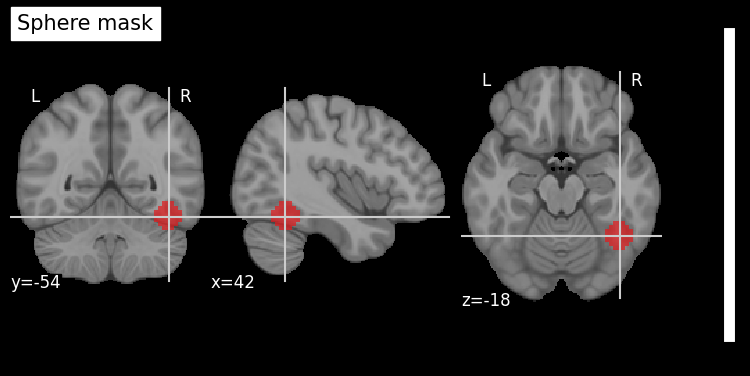

In [7]:
# Load the NIfTI file
base_img = nib.load(effect_files[0]) # The input here can be a BIDSImageFile or a file name string

# Center voxel in voxel-space
center_voxel = tuple(int(coord) for coord in data_from_MNI_coord['voxel'].iloc[0])

# Radius in mm
radius = 10

# fMRIprep preprocessed data contain a brain mask which we can use to constrain the sphere mask
brain_mask_file = layout.get(return_type='file', datatype='func', suffix='mask', desc='brain', space='MNI152NLin6Asym', res='9', extension='nii.gz')[0]
brain_mask = nib.load(brain_mask_file)

# Create the sphere
sphere_mask = create_voxel_sphere(base_img, center_voxel, radius, brain_mask)

# Plot the sphere mask
plot_roi(sphere_mask, bg_img=mni152_template, title='Sphere mask', display_mode='ortho', cmap='Set1')

# # Save the sphere mask to a file
# nib.save(sphere_mask, 'path/where/to/save/sphere_mask.nii.gz')

### Function `create_MNIvoxel_sphere`

This function uses built-in Nilearn functions to achieve the same result as the previous function. It expects the input coordinates to be in MNI-space (or another world-space) coordinates. And the resulting sphere will be constrained to the base_image as a mask. 

In [8]:
from nilearn.maskers import NiftiSpheresMasker
from nilearn.image import new_img_like

def create_MNIvoxel_sphere(base_image, center_mni_coords, radius_mm):
    """
    Create a spherical binary mask centered at given MNI coordinates.

    Parameters:
    - base_image: nibabel Nifti1Image used to define space
    - center_mni_coords: (x, y, z) MNI coordinates
    - radius_mm: sphere radius in millimeters

    Returns:
    - sphere_mask: Nifti1Image (binary mask with sphere)
    """

    # Step 1: Create a binary brain mask
    brain_mask = compute_brain_mask(base_image)

    # Step 2: Define the masker with the mask image
    masker = NiftiSpheresMasker(
        seeds=[center_mni_coords],
        radius=radius_mm,
        mask_img=brain_mask,
        standardize=False,
        detrend=False
    )

    # Step 3: Fit the masker to initialise it
    _ = masker.fit_transform(base_image)

    # Step 4: Generate the sphere mask
    sphere_mask_img = masker.inverse_transform([[1]])

    # Step 5: Binarize it and return
    sphere_mask_data = (sphere_mask_img.get_fdata() > 0).astype(np.uint8)
    # Remove the singleton 4th dimension
    sphere_mask_data = np.squeeze(sphere_mask_data)
    # Create 3D image
    binary_mask = new_img_like(base_image, sphere_mask_data)

    return binary_mask

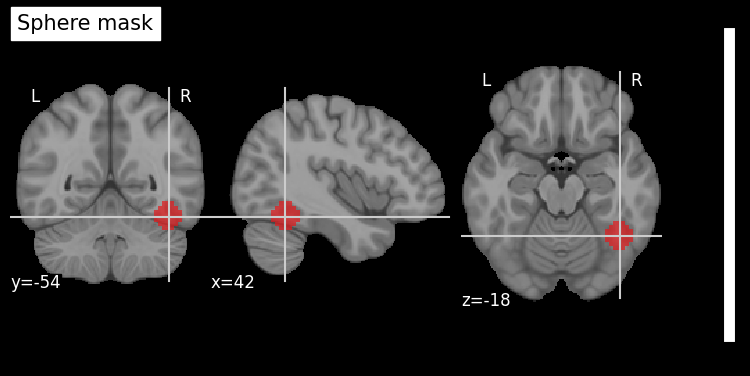

In [9]:
# Center voxel in MNI-space
center_voxel = MNI_coord

# Radius in mm
radius = 10

# Create the sphere
sphere_mask = create_MNIvoxel_sphere(base_img, center_voxel, radius)

# Plot the sphere mask
plot_roi(sphere_mask, bg_img=mni152_template, title='Sphere mask', display_mode='ortho', cmap='Set1')

# # Save the sphere mask to a file
# nib.save(sphere_mask, 'path/where/to/save/sphere_mask.nii.gz')

We can now also create **a joint mask of the sphere and the group-level t-map of Faces>Scrambled contrast** that we saved in the previous tutorial.

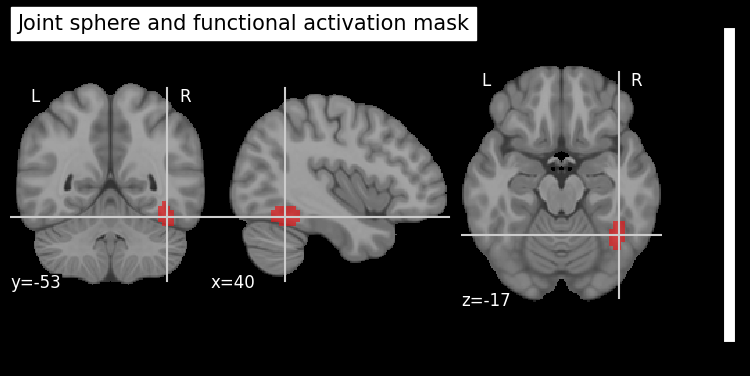

In [10]:
# Create a joint mask of the sphere and the group-level t-map

group_level_t_map_file = op.join(fmri_results_dir, 'group-level', 'FacesScrambled_fwe_t-map.nii.gz')

sphere_and_faces_vs_scrambled_mask = math_img('(img1 * img2) > 0', img1=sphere_mask, img2=group_level_t_map_file) # binary mask of the sphere and the t-map

plot_roi(
  sphere_and_faces_vs_scrambled_mask, 
  bg_img=mni152_template, 
  title='Joint sphere and functional activation mask', 
  display_mode='ortho', 
  cmap='Set1')

### Function `extract_mean_ROI_values`

Once the spherical ROI is created, we can extract and compute the mean activation values within this ROI across multiple fMRI result files. The ROI and fMRI result files must be in the same space (e.g., MNI-space).

In [11]:
def extract_mean_ROI_values(result_files, ROI):
    """
    Extract mean ROI values from a list of results files using a provided ROI mask.

    Parameters:
    - result_files: List of BIDSImageFiles, or a list of file names, containing subject-level results.
    - ROI: Nifti1Image containing the mask data.

    Returns:
    - DataFrame with columns: 'subject', 'condition', 'value'.
    """
    
    # Check if the mask and the file have the same shape (dimensions) and resample if necessary
    first_file = result_files[0]
    if isinstance(first_file, str):
        first_file = layout.get_file(first_file)
    if not ROI.shape == first_file.get_image().shape[:3]:
      ROI = resample_to_img(ROI, first_file.get_image(), interpolation='nearest')
      print(f"Resampled the mask to the shape of result files")
        
    # Initialize an empty list to store the data
    data_list = []

    # Loop through the files and extract the mean ROI values
    for file in result_files:
        # If file is not a BIDSImageFile, but a string, load it
        if isinstance(file, str):
          file = layout.get_file(file)
                 
        # Get the subject ID
        subject = file.get_entities()['subject']
        
        # Get the condition name
        condition = file.get_entities()['desc']
        
        # Get the voxel values within the mask
        img_data = file.get_image()
        mask_data = ROI.get_fdata()
        vox_values = img_data.get_fdata()[mask_data > 0]
        # Compute the mean value
        mean_value = np.mean(vox_values)
        
        # Append the data to the list
        data_list.append([subject, condition, mean_value])
    
    # Convert the list to a pandas DataFrame
    data = pd.DataFrame(data_list, columns=['subject', 'condition', 'value'])
    
    return data

Let's apply the function to extract the mean contrast values within the ROI from each results file. 

In [12]:
data_from_sphere = extract_mean_ROI_values(effect_files, sphere_mask)
print(data_from_sphere)

   subject condition     value
0       01     DelFF  0.409821
1       01     DelUF  0.257402
2       01     ImmFF  0.218296
3       01     ImmUF  0.228966
4       01     IniFF  0.357477
..     ...       ...       ...
91      16     DelUF  0.075776
92      16     ImmFF  0.115598
93      16     ImmUF  0.059675
94      16     IniFF  0.169064
95      16     IniUF  0.101039

[96 rows x 3 columns]


## A ROI from a probabilistic atlas

In this section, we demonstrate how to create an ROI based on probabilistic data from the [Julich-Brain Cytoarchitectonic Atlas](https://search.kg.ebrains.eu/instances/ab191c17-8cd8-4622-aaac-eee11b2fa670). Probabilistic atlases provide voxel-wise information on the likelihood that a particular brain region corresponds to a given area, reflecting inter-individual variability in brain anatomy or function. The atlas is a single 4D image file, with each ROI stored as a separate volume in the file's fourth dimension. It is accompanied by a label file that indicates which volume corresponds to each region.

We selected the Julich-Brain Cytoarchitectonic Atlas for this analysis due to its comprehensive coverage of cytoarchitectonic regions, including the amygdala, which is of particular interest in the provided example. The choice of atlas often depends on the specific requirements of the study, such as the need for detailed cytoarchitectonic information or broader anatomical coverage.

Here, we focus on generating an ROI for the amygdala by extracting and combining relevant regions from the atlas, applying a probability threshold, and creating a binary mask for use in subsequent analyses.

We start by specifying the location of the atlas's image and lable files, and setting the probability threshold. 

When using probabilistic atlases to define ROIs, **the choice of threshold** can significantly affect the final ROI. The threshold determines the minimum probability that a voxel belongs to a particular region, so a higher threshold will result in a smaller, more conservative ROI, while a lower threshold will include more voxels and create a larger ROI. The choice of threshold depends on your specific research question, the size and function of the region you are studying, and the need for either more inclusive or more conservative ROIs. A moderate threshold (20-30%) is frequently used as a balance between inclusivity and specificity. This threshold will exclude voxels that are less likely to belong to the region while still capturing the bulk of the structure.

It’s advisable to visually inspect the resulting ROIs at different thresholds to ensure they are biologically plausible and appropriate for your analysis.

In [13]:
# Define the location of the atlas and labels files
atlas_julich_file = '../example_data/atlases/Julich/JULICH_BRAIN_CYTOARCHITECTONIC_MAPS_2_9_MNI152_2009C_NONL_ASYM.pmaps_resized.nii.gz'
labels_julich_file = '../example_data/atlases/Julich/JULICH_BRAIN_CYTOARCHITECTONIC_MAPS_2_9_MNI152_2009C_NONL_ASYM.txt'

# Set the probability threshold
prob_threshold = 0.25

Next, we identify which volumes in the atlas correspond to the amygdala, our region of interest. We do this by consulting the accompanying label text file, where each ROI in the atlas is assigned a map index. We search for all labels that contain 'amygdala' in their names and extract their map indexes.

In [14]:
# convert labels txt file to dataframe
labels_df = pd.read_csv(labels_julich_file, sep=" ", quotechar="'", names=['mapindex', 'regionname'], skiprows=1)
print(f"Atlas labels:\n{labels_df}\n----------------------------------")

# find the indexes for regions containing amygdala
mapindex_of_interest = labels_df[labels_df['regionname'].str.contains('Amygdala')].index
print(f"Labels of interest:\n{labels_df.loc[mapindex_of_interest]}\n----------------------------------")

Atlas labels:
     mapindex                            regionname
0           1   Frontal-to-Temporal-I (GapMap) left
1           2  Frontal-to-Temporal-I (GapMap) right
2           3         Ch 123 (Basal Forebrain) left
3           4        Ch 123 (Basal Forebrain) right
4           5           Ch 4 (Basal Forebrain) left
..        ...                                   ...
291       292  Fastigial Nucleus (Cerebellum) right
292       293               CGM (Metathalamus) left
293       294              CGM (Metathalamus) right
294       295               CGL (Metathalamus) left
295       296              CGL (Metathalamus) right

[296 rows x 2 columns]
----------------------------------
Labels of interest:
    mapindex            regionname
6          7    LB (Amygdala) left
7          8   LB (Amygdala) right
8          9    CM (Amygdala) left
9         10   CM (Amygdala) right
10        11    SF (Amygdala) left
11        12   SF (Amygdala) right
12        13   VTM (Amygdala) left
13 

Now we can create a binary mask for the amygdala from probabilistic atlas data, applying a probability threshold to ensure that only regions with sufficient likelihood of corresponding to the amygdala are included in the final mask. We do it in the following steps:

1. Load the 4D atlas image.
2. Extract the specific 3D volumes corresponding to the amygdala.
3. Threshold the selected data to create a binary mask for each 3D volume.
4. Combine these 3D images by summing them.
5. Binarise the combined 3D data to create the final binary mask for the amygdala.
6. Convert the combined data, which is a NumPy array, into a 3D NIfTI image. The affine transformation matrix from the original atlas image is used to ensure the mask aligns correctly in the same spatial orientation as the atlas.

In [15]:
# Load the 4D atlas image
atlas_img = nib.load(atlas_julich_file, mmap=True)
atlas_data = atlas_img.get_fdata()

# Select the maps of interest (from the 4th dimension of the 4D image)
selected_data = atlas_data[:, :, :, mapindex_of_interest]

# Threshold the data
thresholded_data = np.where(selected_data > prob_threshold, 1, 0)

# Combine these 3D images by summing them
new_3d_data = np.sum(thresholded_data, axis=-1)

# Binarize the data
new_3d_data = np.where(new_3d_data > 0, 1, 0)

# Cast the data to int8 to avoid compatibility issues
new_3d_data = new_3d_data.astype(np.uint8)

# Create a new NIfTI image with the 3D data
amygdala_mask = nib.Nifti1Image(new_3d_data, atlas_img.affine) # could set dtype here, but setting it above works better (no warnings)

Now we can plot the created amygdala ROI.

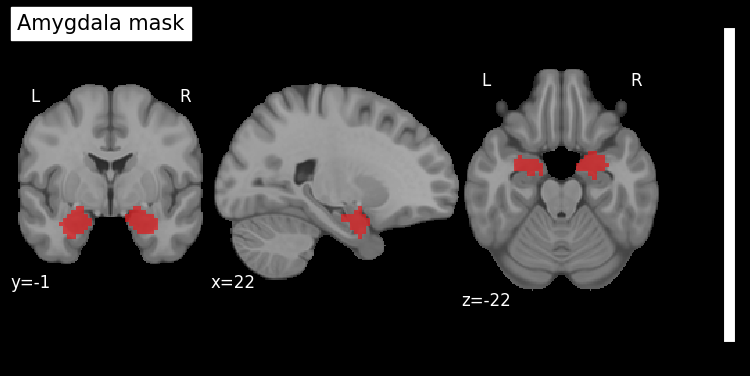

In [16]:
# Plot the amygdala mask
plot_roi(
  amygdala_mask, 
  title='Amygdala mask', 
  display_mode='ortho', 
  draw_cross=False, 
  annotate=True, 
  black_bg=True, 
  bg_img = mni152_template, 
  cmap='Set1')

And once we have the ROI, we can extract the contrast values using the previously created `extract_mean_ROI_values` function.

In [17]:
data_from_amygdala = extract_mean_ROI_values(effect_files, amygdala_mask)
print(data_from_amygdala)

/tmp/ipykernel_1376662/255973940.py:18: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  ROI = resample_to_img(ROI, first_file.get_image(), interpolation='nearest')
/tmp/ipykernel_1376662/255973940.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  ROI = resample_to_img(ROI, first_file.get_image(), interpolation='nearest')


Resampled the mask to the shape of result files
   subject condition     value
0       01     DelFF  0.128927
1       01     DelUF  0.096503
2       01     ImmFF  0.030295
3       01     ImmUF  0.013445
4       01     IniFF  0.068432
..     ...       ...       ...
91      16     DelUF  0.003778
92      16     ImmFF -0.002997
93      16     ImmUF  0.064229
94      16     IniFF  0.065601
95      16     IniUF -0.001708

[96 rows x 3 columns]


An important aspect to note is that the dimensions of the created amygdala ROI differ from those of the results files. For data extraction to occur correctly, the dimensions of the two must match. We have addressed this in our `extract_mean_ROI_values` function. If the ROI's dimensions do not match those of the results file, the ROI is resampled to align with the results file.

In [18]:
# Check the shape of the amygdala mask and the result files
print("Amygdala mask shape:", amygdala_mask.shape[:3])
print("Result files shape:", effect_files[0].get_image().shape[:3])

# Check the voxel dimensions of the amygdala mask
vox_dims = np.diag(amygdala_mask.affine)[:3]
print(f"Voxel dimensions of the amygdala mask: {vox_dims}")

# Check the voxel dimensions of the result files
vox_dims = np.diag(effect_files[0].get_image().affine)[:3]
print(f"Voxel dimensions of the result files: {vox_dims}")


Amygdala mask shape: (64, 76, 64)
Result files shape: (61, 73, 61)
Voxel dimensions of the amygdala mask: [3. 3. 3.]
Voxel dimensions of the result files: [3. 3. 3.]


## Transforming MNI-space ROI to native-space for native-space analysis

In the final example, we demonstrate how to transform an ROI defined in MNI space (e.g., a spherical mask) into a subject's native space using a transformation matrix derived during preprocessing with fMRIPrep. Once transformed, the ROI can be used to extract activation values from the native-space data of individual subjects, which may provide more accurate results than performing the analysis on normalized data.

In this example, we will use the ANTs Python package [ANTsPy](https://github.com/ANTsX/ANTsPy) to perform the transformation.

/tmp/ipykernel_1376662/1449992875.py:6: UserWarning: Casting data from int16 to float32
  plot_roi(sphere_mask, bg_img=sub_anat_file, title=f"{ROI_label} sphere mask in native space; incorrect", display_mode='ortho', dim=-1, cmap='Set1')


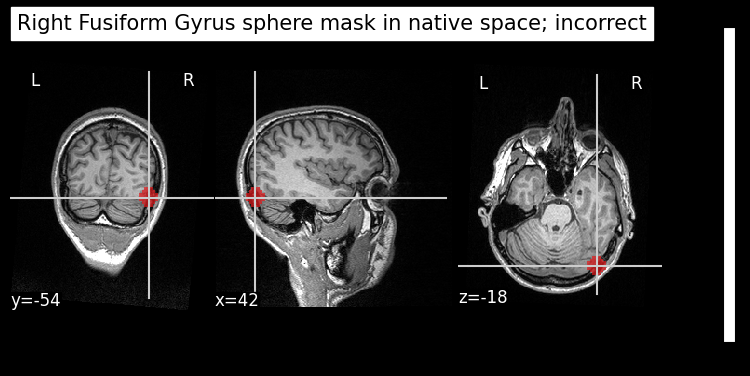

In [19]:
# check the MNI sphere on subject's native space anatomical image

sID = '15'
sub_anat_file = layout.get(subject=sID, datatype='anat', suffix='T1w', extension='nii.gz', desc=None, return_type='file')[0]

plot_roi(sphere_mask, bg_img=sub_anat_file, title=f"{ROI_label} sphere mask in native space; incorrect", display_mode='ortho', dim=-1, cmap='Set1')

Found the following transformation file: /imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/anat/sub-15_ses-mri_from-MNI152NLin6Asym_to-T1w_mode-image_xfm.h5


/tmp/ipykernel_1376662/2316194873.py:19: UserWarning: Casting data from int16 to float32
  plot_roi(ROI_native_space, bg_img=sub_anat_file, title=f"{ROI_label} sphere mask in native space; correct", display_mode='ortho', dim=-1, cmap='Set1')


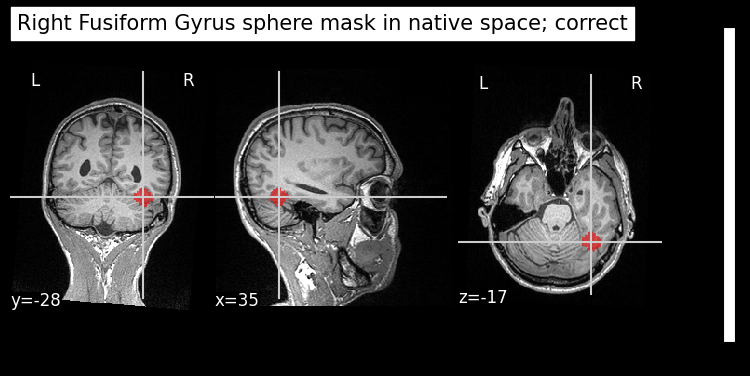

In [21]:
MNI_to_native_xfm_path = layout.get(subject=sID, datatype='anat', extension='h5', to='T1w', return_type='file')[0]
print(f"Found the following transformation file: {MNI_to_native_xfm_path}")

# save sphere mask to disk
MNI_mask_file = '../example_data/FaceRecognition/scratch/sphere_mask.nii.gz'
nib.save(sphere_mask, MNI_mask_file)

# Apply the transformation to the sphere mask
ROI_native_space = ants.apply_transforms(
  fixed = ants.image_read(sub_anat_file), 
  moving = ants.image_read(MNI_mask_file),
  transformlist = MNI_to_native_xfm_path, 
  interpolator = 'nearestNeighbor')

# Convert ants image to nibabel image
ROI_native_space = nib.Nifti1Image(ROI_native_space.numpy(), nib.load(sub_anat_file).affine)

# plot the ROI in native space
plot_roi(ROI_native_space, bg_img=sub_anat_file, title=f"{ROI_label} sphere mask in native space; correct", display_mode='ortho', dim=-1, cmap='Set1')


Importantly, when working in MNI space, a single ROI mask file is sufficient for the entire group since all subjects are aligned to the same space. However, in native space, each subject requires a unique ROI mask due to the individual differences in brain anatomy. As a result, the `extract_mean_ROI_values` function must be applied separately to each subject's results files.

## Statistics and plotting of the ROI data

Now that we have created the ROI masks and extracted the data, we can proceed with statistical analyses as we would with any other dataset. Below are some examples of the ROI analysis results for our example dataset.

### Paired t-test: Initial vs Repeated Faces in the Right Fussiform Gyrus

In [22]:
data = data_from_MNI_coord # or data_from_sphere

# Paired t-test

# Separate the data into Initial and Repetition presentations
initial = data[data['condition'].isin(['IniFF', 'IniUF'])].groupby('subject')['value'].mean()
repeated = data[data['condition'].isin(['ImmFF', 'DelFF', 'ImmUF', 'DelUF'])].groupby('subject')['value'].mean()

# Perform the paired t-test
t_stat, p_value = stats.ttest_rel(initial, repeated)
print(f"Initial vs Repeated presentation of faces in the {ROI_label}. \nPaired t-test results: t-statistic = {t_stat}, p-value = {p_value}")


Initial vs Repeated presentation of faces in the Right Fusiform Gyrus. 
Paired t-test results: t-statistic = 4.987342003114323, p-value = 0.00016230349637060668


In [23]:
# Create a long format DataFrame for the plot
data_initial_repeated = pd.DataFrame({
    'condition': ['initial'] * len(initial) + ['repeated'] * len(repeated),
    'value': pd.concat([initial, repeated]).reset_index(drop=True),
    'subject': list(initial.index) + list(repeated.index)
})
print(data_initial_repeated)

   condition     value subject
0    initial  0.348618      01
1    initial  0.454349      02
2    initial  0.158633      03
3    initial  0.232917      04
4    initial  0.415702      05
5    initial  0.284959      06
6    initial  0.187756      07
7    initial  0.677417      08
8    initial  0.362556      09
9    initial  0.342857      10
10   initial  0.310000      11
11   initial  0.460329      12
12   initial  0.572247      13
13   initial  0.383347      14
14   initial  0.404532      15
15   initial  0.186891      16
16  repeated  0.266181      01
17  repeated  0.377596      02
18  repeated  0.227035      03
19  repeated  0.149838      04
20  repeated  0.270373      05
21  repeated  0.149246      06
22  repeated  0.092535      07
23  repeated  0.514292      08
24  repeated  0.221570      09
25  repeated  0.271434      10
26  repeated  0.137194      11
27  repeated  0.169884      12
28  repeated  0.462920      13
29  repeated  0.303918      14
30  repeated  0.417371      15
31  repe

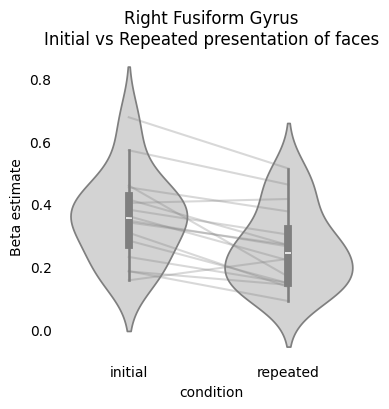

In [24]:
plt.figure(figsize=(4, 4))

# Plot the point plot with dodge to avoid overlap
sns.violinplot(x='condition', y='value', data=data_initial_repeated, linestyles='-', color='lightgrey')

# Add lines
for subject in data_initial_repeated['subject'].unique():
    subject_data = data_initial_repeated[data_initial_repeated['subject'] == subject]
    plt.plot([0, 1], subject_data['value'], color='gray', alpha=0.3)

# Remove plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Remove tick marks but keep the labels
plt.tick_params(axis='both', which='both', length=0)  # Set tick marks length to 0

plt.ylabel('Beta estimate')
plt.title(f"{ROI_label}\nInitial vs Repeated presentation of faces")
plt.show()

### Three-way RM ANOVA. Initial vs Immediate Repetition vs Delayed Repetition in the Right Fusiform Gyrus

In [25]:
# Repeated measures ANOVA

initial = data[data['condition'].isin(['IniFF', 'IniUF'])].groupby('subject')['value'].mean()
immediate_rep = data[data['condition'].isin(['ImmFF', 'ImmUF'])].groupby('subject')['value'].mean()
delayed_rep = data[data['condition'].isin(['DelFF', 'DelUF'])].groupby('subject')['value'].mean()

# Create a long format DataFrame
data_3way_presentation = pd.DataFrame({
    'condition': ['initial'] * len(initial) + ['immediate'] * len(immediate_rep) + ['delayed'] * len(delayed_rep),
    'value': pd.concat([initial, immediate_rep, delayed_rep]).reset_index(drop=True),
    'subject': list(initial.index) + list(immediate_rep.index) + list(delayed_rep.index)
})

#print(data_3way_presentation)


In [26]:

# Perform repeated measures ANOVA
anova = AnovaRM(data_3way_presentation, 'value', 'subject', within=['condition'])
anova_results = anova.fit()

print(anova_results)

tukey = pairwise_tukeyhsd(endog=data_3way_presentation['value'], groups=data_3way_presentation['condition'], alpha=0.05)

print(tukey) # Tukey’s HSD: This test compares all possible pairs of means and controls the family-wise error rate.


                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition 27.5933 2.0000 30.0000 0.0000

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
  delayed immediate  -0.0999 0.0996 -0.2148  0.015  False
  delayed   initial   0.0505 0.5398 -0.0643 0.1654  False
immediate   initial   0.1504 0.0075  0.0355 0.2653   True
---------------------------------------------------------


#### A simple plot

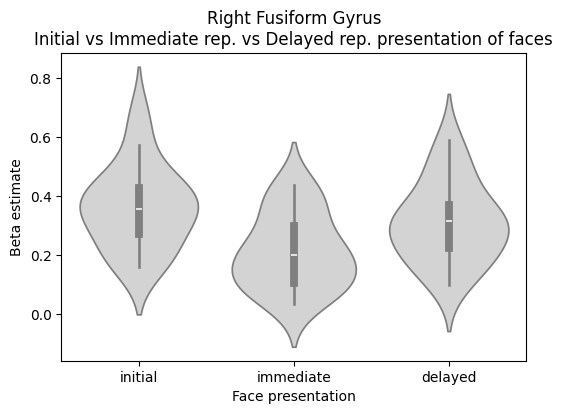

In [27]:
# plot data_3way_presentation
condition_order = ['initial', 'immediate', 'delayed']

plt.figure(figsize=(6, 4))
sns.violinplot(x='condition', y='value', data=data_3way_presentation, color='lightgrey', order=condition_order)
plt.ylabel('Beta estimate')
plt.xlabel('Face presentation')
plt.title(f"{ROI_label}\nInitial vs Immediate rep. vs Delayed rep. presentation of faces")
plt.show()

#### A 'publication-ready' plot

In [28]:
def plot_1by3_anova(data, subject_col, condition_col, value_col, condition_order, 
                    roi_label='', mni_coord='', title='', xlabel='', ylabel='', xticks=[]):
    """
    Plots the results of a 1-by-3 ANOVA with within-subject 95% confidence intervals and significance annotations.
    
    Parameters:
    - data: DataFrame containing the data (long format).
    - subject_col: Name of the column representing subjects.
    - condition_col: Name of the column representing the condition.
    - value_col: Name of the column representing the dependent variable.
    - condition_order: List specifying the order of conditions.
    - roi_label: Label for the region of interest (ROI).
    - mni_coord: MNI coordinates as a string.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - xticks: List of custom x-axis labels.
    - title: Title for the plot.
    
    Returns:
    - A plot of the ANOVA results with error bars and significance markers.
    """    
    # Perform ANOVA
    anova = AnovaRM(data_3way_presentation, 'value', 'subject', within=['condition'])
    anova_results = anova.fit()
    
    # Get the ANOVA F-value and p-value for the plot title
    F_value = anova_results.anova_table['F Value'].iloc[0]
    
    if anova_results.anova_table['Pr > F'].iloc[0] < 0.001:
        p_value = "< 0.001"
    else:
        p_value = f"= {anova_results.anova_table['Pr > F'].iloc[0]:.3f}"
        
    # Perform Tukey's HSD test
    tukey_results = pairwise_tukeyhsd(endog=data_3way_presentation['value'], groups=data_3way_presentation['condition'], alpha=0.05)
    print(tukey_results)
    
    # Determine the significance markers for the pairs based on the Tukey's HSD test
    annotations = ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'n.s.' for p in tukey_results.pvalues]
    
    # --------------------------------------------------------------
    # Match pairs to annotations based on the Tukey's HSD test results
    # --------------------------------------------------------------
    # Get condition labels from Tukey results
    tukey_conditions = np.array(tukey_results.groupsunique) 

    # Map conditions to their indices in the user-specified order
    condition_indices = {cond: i for i, cond in enumerate(condition_order)}

    # Extract and sort pairs according to the specified condition order
    pair_indices = tukey_results._multicomp.pairindices 
    
    group1_idx, group2_idx = pair_indices 
    tukey_pairs = list(zip(tukey_conditions[group1_idx], tukey_conditions[group2_idx]))

    # Map Tukey pairs to specified condition indices
    pairs = [(condition_indices[g1], condition_indices[g2]) for g1, g2 in tukey_pairs]

    # --------------------------------------------------------------
    
    # Ensure 'subject' and 'condition' are categorical variables
    data[subject_col] = data[subject_col].astype('category')
    data[condition_col] = data[condition_col].astype('category')
    
    # Calculate the mean for each condition
    means = data.groupby(condition_col, observed=True)[value_col].mean()
    
    # Subtract the participant's mean value from each score to calculate deviations
    data['deviation'] = data[value_col] - data.groupby(subject_col, observed=True)[value_col].transform('mean')
    
    # Calculate the standard error of the mean for each condition
    sem = data.groupby(condition_col, observed=True)['deviation'].std() / np.sqrt(data[subject_col].nunique())
    
    # Calculate the t-value for the 95% confidence interval
    t_value = stats.t.ppf(1 - 0.025, data[subject_col].nunique() - 1)  # degrees of freedom = n-1
    
    # Calculate the confidence interval
    ci = sem * t_value
    
    # Plot the data
    plt.figure(figsize=(6, 8))
    
    # Create a point plot
    sns.pointplot(data=data, x=condition_col, y=value_col, order=condition_order, capsize=.1, errorbar=None, color='black', markers='o', linestyles='-', estimator=np.mean)
    
    # Add error bars using the calculated within-subject CI
    plt.errorbar(x=range(len(means)), y=means[condition_order], yerr=ci[condition_order], fmt='none', capsize=5, color='black')
    
    # Add individual data points
    sns.stripplot(data=data, x=condition_col, y=value_col, order=condition_order, color='grey', alpha=0.6, jitter=True)
    
    # Annotate the plot with significance markers
    y_max = data[value_col].max() + (data[value_col].max() * 0.04)  # Position above the highest point
    y_range = data[value_col].max() + (data[value_col].max() * 0.07)  # Adjust the range to avoid overlapping
    
    for i, (pair, annotation) in enumerate(zip(pairs, annotations)):
        x1, x2 = pair
        y = y_max + (i * 0.05)  # Space annotations vertically
        plt.plot([x1, x2], [y, y], color='black', lw=1.5)
        plt.text((x1 + x2) * 0.5, y + 0.01, annotation, ha='center', va='bottom', color='black')
    
    # Add horizontal line at 0
    plt.axhline(y=0, color='grey')
    
    # Remove plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    
    # Remove tick marks but keep the labels
    plt.tick_params(axis='both', which='both', length=0)  
    
    # Add labels and title
    plt.xlabel(f'\n{xlabel}')
    plt.ylabel(ylabel)
    
    # Custom x labels
    plt.xticks(ticks=range(len(means)), labels=xticks)
    
    # Set title
    plt.title(f"{title} \n F = {F_value:.2f}, p {p_value}; error bars: within-subj 95% CI")
    
    # Show plot
    plt.show()

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
  delayed immediate  -0.0999 0.0996 -0.2148  0.015  False
  delayed   initial   0.0505 0.5398 -0.0643 0.1654  False
immediate   initial   0.1504 0.0075  0.0355 0.2653   True
---------------------------------------------------------


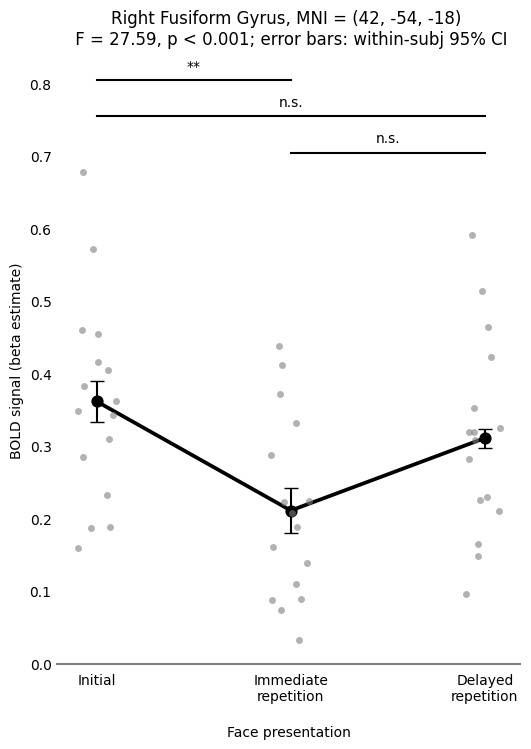

In [29]:
plot_1by3_anova(
    data=data_3way_presentation,
    subject_col='subject',
    condition_col='condition',
    value_col='value',
    condition_order=['initial', 'immediate', 'delayed'],
    roi_label=ROI_label,
    mni_coord=MNI_coord,
    xlabel='Face presentation',
    ylabel='BOLD signal (beta estimate)', 
    xticks=['Initial', 'Immediate\nrepetition', 'Delayed\nrepetition'], 
    title=f"{ROI_label}, MNI = {MNI_coord}"
)


### Two-by-Two RM ANOVA. Repetition effect for Familiarity x Lag in the Right Fusiform Gurys

> 
> *"Behavioural priming has been found for both familiar and unfamiliar faces when repeated immediately, but only for familiar faces when repeated after a delay."* [(Henson et al., 2004)](https://www.mrc-cbu.cam.ac.uk/personal/rik.henson/personal/HensonEtAl_HBM_Abstract_04.pdf)
> 

Do we find this in our fMRI results? 

**Do repetition effect for Familiarity (Famous, Unfamiliar) X Lag (Immediate, Delayed) ANOVA**

In [30]:
# Pivot the DataFrame and reset the (subject) index
df_pivot = data.pivot(index='subject', columns='condition', values='value').reset_index()

# Get the repetition suppression effect for each repetition condition for each subject.
df_pivot['DelFF'] -= df_pivot['IniFF']
df_pivot['ImmFF'] -= df_pivot['IniFF']
df_pivot['DelUF'] -= df_pivot['IniUF']
df_pivot['ImmUF'] -= df_pivot['IniUF']

# Reshape the DataFrame to long format
df_rs = df_pivot.melt(id_vars=['subject'], 
                      value_vars=['DelFF', 'ImmFF', 'DelUF', 'ImmUF'], 
                      var_name='condition', 
                      value_name='repetition_effect')

# Extracting factors from the condition names
df_rs['familiarity'] = df_rs['condition'].apply(lambda x: 'Famous' if 'FF' in x else 'Unfamiliar')
df_rs['lag'] = df_rs['condition'].apply(lambda x: 'Immediate' if 'Imm' in x else 'Delayed')

# Print or save the resulting DataFrame
print(df_rs)


   subject condition  repetition_effect familiarity        lag
0       01     DelFF           0.061856      Famous    Delayed
1       02     DelFF           0.002826      Famous    Delayed
2       03     DelFF          -0.004175      Famous    Delayed
3       04     DelFF           0.010844      Famous    Delayed
4       05     DelFF          -0.046679      Famous    Delayed
..     ...       ...                ...         ...        ...
59      12     ImmUF          -0.413491  Unfamiliar  Immediate
60      13     ImmUF          -0.200051  Unfamiliar  Immediate
61      14     ImmUF          -0.055160  Unfamiliar  Immediate
62      15     ImmUF          -0.078464  Unfamiliar  Immediate
63      16     ImmUF          -0.049233  Unfamiliar  Immediate

[64 rows x 5 columns]


In [31]:
# Perform the repeated measures ANOVA
aovrm = AnovaRM(df_rs, depvar='repetition_effect', subject='subject', within=['familiarity', 'lag'])
res = aovrm.fit()

# Print the results
print(res)

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
familiarity      0.9590 1.0000 15.0000 0.3430
lag             32.3668 1.0000 15.0000 0.0000
familiarity:lag  0.1000 1.0000 15.0000 0.7562



In [32]:
def plot_nbyn_anova(data, subject_col, condition_cols, value_col, 
                    condition_order=None, line_colors=None,  
                    xlabel='', ylabel='', title=''):
    """
    Plots the results of an n-by-n ANOVA with within-subject 95% confidence intervals.
    
    Parameters:
    - data: DataFrame containing the data.
    - subject_col: Name of the column representing subjects.
    - condition_cols: List of columns representing the conditions (e.g., ['familiarity', 'presentation']).
    - value_col: Name of the column representing the dependent variable.
    - condition_order: List specifying the order of levels within each condition.
    - line_colors: List of colors for each condition.
    - title: Title for the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - title: Title for the plot.
    
    Returns:
    - A plot of the ANOVA results with error bars.
    """
    
    # --------------------------------------------------------------------------------------------
    # Calculate within-subject 95% confidence intervals
    # --------------------------------------------------------------------------------------------

    # Ensure subject and condition columns are categorical
    data[subject_col] = data[subject_col].astype('category')
    for condition_col in condition_cols:
        data[condition_col] = data[condition_col].astype('category')
    
    # Calculate the mean for each condition combination
    means = data.groupby(condition_cols, observed=True)[value_col].mean()

    # Subtract the participant's mean value from each score to calculate deviations
    data['deviation'] = data[value_col] - data.groupby(subject_col, observed=True)[value_col].transform('mean')

    # Calculate the standard error of the mean for each condition combination
    sem = data.groupby(condition_cols, observed=True)['deviation'].std() / np.sqrt(data[subject_col].nunique())

    # Calculate the t-value for the 95% confidence interval
    t_value = stats.t.ppf(1 - 0.025, data[subject_col].nunique() - 1)

    # Calculate the confidence interval
    ci = sem * t_value
    
    
    # Print the means and confidence intervals
    print("\n----------------------------------------\n")
    print("Condition means:" + "\n" + str(means))
    print("\n----------------------------------------\n")
    print("Condition CIs:" + "\n" + str(ci))
    print("\n----------------------------------------\n")

    # --------------------------------------------------------------------------------------------
    # Plot the data
    # --------------------------------------------------------------------------------------------
    plt.figure(figsize=(4, 4))
    
    ax = sns.pointplot(
        data=data, x=condition_cols[-1], y=value_col, hue=condition_cols[0],
        errorbar=None, palette=line_colors, order=condition_order, dodge=0.02
    )

    # Extract x positions for error bars
    positions = [x_value for line in ax.lines for x_value in line.get_xdata()]

    # Get the legend from the axis to know which line corresponds to which condition
    legend = ax.get_legend()
    legend_labels = [text.get_text() for text in legend.get_texts()]

    # Extract means and error values
    mean_values = []
    error_values = []
    for label in legend_labels:
        for condition in condition_order:
            mean_values.append(means[label, condition])
            error_values.append(ci[label, condition])

    # Plotting the error bars in a loop
    for i in range(len(positions)):
        plt.errorbar(x=positions[i], y=mean_values[i], yerr=error_values[i],
                     fmt='none', capsize=5, color=line_colors[i // len(condition_order)])

    # Remove plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    # Remove tick marks but keep the labels
    plt.tick_params(axis='both', which='both', length=0)

    # Remove the legend title
    plt.gca().legend().set_title(None)

    # Add horizontal line at 0
    plt.axhline(y=0, color='black', linewidth=0.5)

    # Add labels and title
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()


----------------------------------------

Condition means:
familiarity  lag      
Famous       Delayed     -0.047067
             Immediate   -0.141577
Unfamiliar   Delayed     -0.053988
             Immediate   -0.159274
Name: repetition_effect, dtype: float64

----------------------------------------

Condition CIs:
familiarity  lag      
Famous       Delayed      0.035919
             Immediate    0.028182
Unfamiliar   Delayed      0.026684
             Immediate    0.025309
Name: deviation, dtype: float64

----------------------------------------



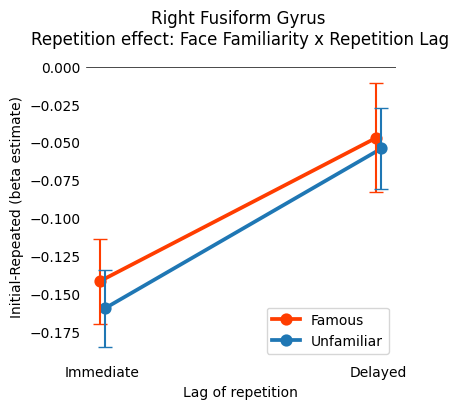

In [33]:
plot_nbyn_anova(
    data=df_rs,
    subject_col='subject',
    condition_cols=['familiarity', 'lag'],
    value_col='repetition_effect',
    condition_order=['Immediate', 'Delayed'],
    line_colors=['#ff3d00', '#1f77b4'],
    ylabel='Initial-Repeated (beta estimate)',
    xlabel='Lag of repetition',
    title=f"{ROI_label} \nRepetition effect: Face Familiarity x Repetition Lag",
)

### Familiar vs Unfamiliar Faces in Amygdala

In [34]:
# data_from_amygdala = extract_mean_ROI_values(effect_files, amygdala_mask)
print(data_from_amygdala)

   subject condition     value
0       01     DelFF  0.128927
1       01     DelUF  0.096503
2       01     ImmFF  0.030295
3       01     ImmUF  0.013445
4       01     IniFF  0.068432
..     ...       ...       ...
91      16     DelUF  0.003778
92      16     ImmFF -0.002997
93      16     ImmUF  0.064229
94      16     IniFF  0.065601
95      16     IniUF -0.001708

[96 rows x 3 columns]


But repetition effects can affect these results. To avoid that and only test the face familiarity effect, let's only use the initial presentations from the two conditions. 

In [35]:
famous = data_from_amygdala[data_from_amygdala['condition'] == 'IniFF'].groupby('subject')['value'].mean()
unfamiliar = data_from_amygdala[data_from_amygdala['condition'] == 'IniUF'].groupby('subject')['value'].mean()

# Perform the paired t-test
t_stat, p_value = stats.ttest_rel(famous, unfamiliar)
print(f"Paired t-test results: t-statistic = {t_stat}, p-value = {p_value}")

Paired t-test results: t-statistic = 2.4122936630259533, p-value = 0.029116384353014717


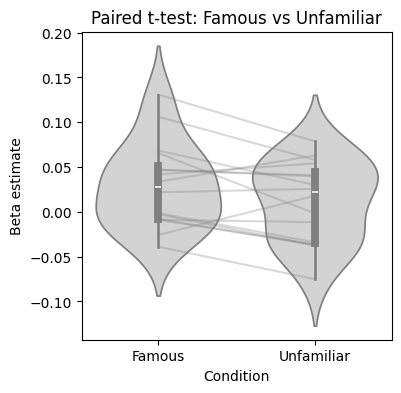

In [36]:
data_famous_unfamiliar = pd.DataFrame({
    'Condition': ['Famous'] * len(famous) + ['Unfamiliar'] * len(unfamiliar),
    'Value': pd.concat([famous, unfamiliar]),
    'Subject': list(famous.index) + list(unfamiliar.index)
})

# Adjust the figure size to make it narrower
plt.figure(figsize=(4, 4))  # Reduce the width (first number) to make the plot narrower

# Plot the point plot with dodge to avoid overlap
sns.violinplot(x='Condition', y='Value', data=data_famous_unfamiliar, linestyles='-', color='lightgrey')

# Add lines
for subject in data_famous_unfamiliar['Subject'].unique():
    subject_data = data_famous_unfamiliar[data_famous_unfamiliar['Subject'] == subject]
    plt.plot([0, 1], subject_data['Value'], color='gray', alpha=0.3)

plt.ylabel('Beta estimate')
plt.title('Paired t-test: Famous vs Unfamiliar')
plt.show()

Are the repetition effects indeed affecting the familiarity effect? 

In [37]:
# Create a data frame from amygdala_data for a 2-by-2 repeated measures ANOVA with factors 'familiarity' (Famous, Unfamiliar) and 'presentation' (Initial, Repeated). 
# Average the im and dl conditions for the repeated presentation.

data_from_amygdala['familiarity'] = data_from_amygdala['condition'].apply(lambda x: 'Famous' if 'FF' in x else 'Unfamiliar')
data_from_amygdala['presentation'] = data_from_amygdala['condition'].apply(lambda x: 'Initial' if 'Ini' in x else 'Repeated')

# For repeated conditions, average the 'dl' and 'im' presentations
def compute_average(df, condition_name):
    return df[df['condition'].str.contains(condition_name)].groupby(['subject', 'familiarity', 'presentation'])['value'].mean().reset_index()

# Get the initial presentations
initial_df = data_from_amygdala[data_from_amygdala['presentation'] == 'Initial']

# Get the repeated presentations by averaging dl and im
repeated_df = compute_average(data_from_amygdala, 'Del|Imm')

# Combine both initial and repeated into the final DataFrame for ANOVA
data_amygdala_initial_repeated = pd.concat([initial_df, repeated_df], axis=0).sort_values(by=['subject', 'familiarity', 'presentation']).reset_index(drop=True)

# Drop the now redundant 'condition' column
data_amygdala_initial_repeated.drop(columns=['condition'], inplace=True)

# Display the final DataFrame
print(data_amygdala_initial_repeated)


   subject     value familiarity presentation
0       01  0.068432      Famous      Initial
1       01  0.079611      Famous     Repeated
2       01  0.029970  Unfamiliar      Initial
3       01  0.054974  Unfamiliar     Repeated
4       02 -0.025692      Famous      Initial
..     ...       ...         ...          ...
59      15  0.015480  Unfamiliar     Repeated
60      16  0.065601      Famous      Initial
61      16 -0.009340      Famous     Repeated
62      16 -0.001708  Unfamiliar      Initial
63      16  0.034004  Unfamiliar     Repeated

[64 rows x 4 columns]


In [38]:
# Perform the repeated measures ANOVA
aovrm = AnovaRM(data_amygdala_initial_repeated, depvar='value', subject='subject', within=['familiarity', 'presentation'])
res = aovrm.fit()

# Print the results
print(res)

                        Anova
                         F Value Num DF  Den DF Pr > F
------------------------------------------------------
familiarity               2.0425 1.0000 15.0000 0.1735
presentation              2.2284 1.0000 15.0000 0.1562
familiarity:presentation  1.2907 1.0000 15.0000 0.2737




----------------------------------------

Condition means:
familiarity  presentation
Famous       Initial         0.029265
             Repeated        0.004737
Unfamiliar   Initial         0.010904
             Repeated        0.003114
Name: value, dtype: float64

----------------------------------------

Condition CIs:
familiarity  presentation
Famous       Initial         0.014046
             Repeated        0.013854
Unfamiliar   Initial         0.014159
             Repeated        0.020279
Name: deviation, dtype: float64

----------------------------------------



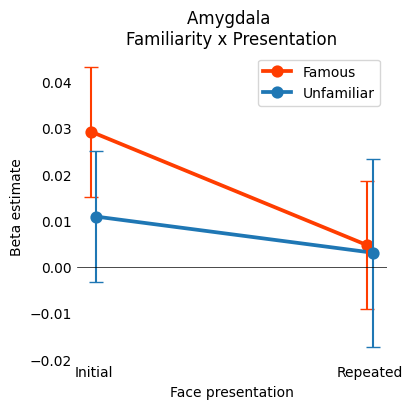

In [39]:
plot_nbyn_anova(
    data=data_amygdala_initial_repeated,
    subject_col='subject',
    condition_cols=['familiarity', 'presentation'],
    value_col='value',
    condition_order=['Initial', 'Repeated'],
    line_colors=['#ff3d00', '#1f77b4'],
    ylabel='Beta estimate',
    xlabel='Face presentation',
    title="Amygdala \nFamiliarity x Presentation",
)

Let's explore it even further - for all three levels of presentation. This will be a 2-by-3 ANOVA. 

In [40]:
# create a copy of the data
data_amygdala_3levels = data_from_amygdala.copy()

# Create new columns to identify 'familiarity' and 'presentation' levels
data_amygdala_3levels['familiarity'] = data_amygdala_3levels['condition'].apply(lambda x: 'Famous' if 'FF' in x else 'Unfamiliar')

def get_presentation_level(condition):
    if 'Ini' in condition:
        return 'Initial'
    elif 'Del' in condition:
        return 'Delayed'
    elif 'Imm' in condition:
        return 'Immediate'
    return None

data_amygdala_3levels['presentation'] = data_amygdala_3levels['condition'].apply(get_presentation_level)


print(data_amygdala_3levels)  


   subject condition     value familiarity presentation
0       01     DelFF  0.128927      Famous      Delayed
1       01     DelUF  0.096503  Unfamiliar      Delayed
2       01     ImmFF  0.030295      Famous    Immediate
3       01     ImmUF  0.013445  Unfamiliar    Immediate
4       01     IniFF  0.068432      Famous      Initial
..     ...       ...       ...         ...          ...
91      16     DelUF  0.003778  Unfamiliar      Delayed
92      16     ImmFF -0.002997      Famous    Immediate
93      16     ImmUF  0.064229  Unfamiliar    Immediate
94      16     IniFF  0.065601      Famous      Initial
95      16     IniUF -0.001708  Unfamiliar      Initial

[96 rows x 5 columns]



----------------------------------------

Condition means:
familiarity  presentation
Famous       Delayed         0.002533
             Immediate       0.006940
             Initial         0.029265
Unfamiliar   Delayed         0.010282
             Immediate      -0.004055
             Initial         0.010904
Name: value, dtype: float64

----------------------------------------

Condition CIs:
familiarity  presentation
Famous       Delayed         0.019211
             Immediate       0.015057
             Initial         0.017328
Unfamiliar   Delayed         0.020891
             Immediate       0.022761
             Initial         0.017451
Name: deviation, dtype: float64

----------------------------------------



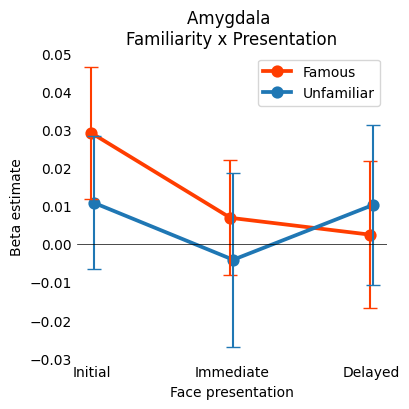

In [41]:
plot_nbyn_anova(
    data=data_amygdala_3levels,
    subject_col='subject',
    condition_cols=['familiarity', 'presentation'],
    value_col='value',
    condition_order=['Initial', 'Immediate', 'Delayed'],
    line_colors=['#ff3d00', '#1f77b4'],
    ylabel='Beta estimate',
    xlabel='Face presentation',
    title="Amygdala \nFamiliarity x Presentation",
)